In [1]:
from datasets import build_dataset
import argparse
import opts

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import cv2
from io import BytesIO
import base64
from PIL import Image
from openai import OpenAI

### 1. 데이터 불러오기

In [2]:
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]

parser = argparse.ArgumentParser('ReferFormer training and evaluation script', parents=[opts.get_args_parser()])
args = parser.parse_args()

In [3]:
args.a2d_path = "/home/yejin/data/dataset/a2d_sentences"

In [4]:
train_dataset = build_dataset('a2d', image_set = 'train', args = args)
text_annotations = train_dataset.text_annotations


 train sample num:  15747




In [5]:
val_dataset = build_dataset('a2d', image_set = 'val', args = args)
text_annotations_val = val_dataset.text_annotations


 val sample num:  3800




In [ ]:
def plot_frame(idx, dataset, text_annotations):
    imgs, target = dataset[idx]
    frames_idx = target['frames_idx'].tolist()
    text_query, vid_id, frame_id, instance_id = text_annotations[idx]
    
    frame_id = frame_id - 1
    frame_order = frames_idx.index(frame_id)

    frame = imgs[frame_order, :, :, :].permute(1, 2, 0).numpy()
    mask = target['masks'].numpy().astype(np.uint8).squeeze()

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, contours, -1, [255, 0, 0], 2)

    plt.figure(figsize=(6, 10))
    plt.imshow(frame)
    plt.title(text_query)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

In [8]:
# for i in range(20):
#     plot_frame(i, train_dataset, text_annotations)

In [9]:
# for i in range(20):
#     plot_frame(i, val_dataset, text_annotations_val)

### 2. ref exp 만들기

In [7]:
def mark_object_and_encode(frame, mask, instance_id, text_query, color_mask=False, label_number=False):
    if color_mask == True:
        alpha = 0.1

        colored_mask = np.zeros_like(frame)
        colored_mask[mask == 1] = [255, 0, 0]
        frame[mask == 1] = (
            (1 - alpha) * frame[mask == 1] +
            alpha * colored_mask[mask == 1]
        )

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, contours, -1, [255, 0, 0], 2)

    if label_number == True:
        if len(contours) > 0:
            largest_contour = max(contours, key=cv2.contourArea)
            M = cv2.moments(largest_contour)
            if M["m00"] != 0:  
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])
            else:
                center_x, center_y = 0, 0

            font = cv2.FONT_HERSHEY_SIMPLEX
            text = str(instance_id)
            font_scale = 0.6  
            text_size = cv2.getTextSize(text, font, font_scale, 2)[0]                        
            text_x = center_x - text_size[0] // 1  
            text_y = center_y

            rect_start = (text_x - 5, text_y - text_size[1] - 5)
            rect_end = (text_x + text_size[0] + 5, text_y)
            
            cv2.rectangle(frame, rect_start, rect_end, (0, 0, 0), -1)
            cv2.putText(frame, text, (text_x, text_y), font, font_scale, (255, 255, 255), 2)

    plt.figure(figsize=(6, 10))
    plt.imshow(frame)
    plt.title(text_query)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

    buffer = BytesIO()
    frame = Image.fromarray(frame)
    frame.save(buffer, format='jpeg')
    buffer.seek(0)
    encoded_frame = base64.b64encode(buffer.read()).decode("utf-8")

    return encoded_frame

In [ ]:
os.environ['OPENAI_API_KEY'] = ""

### a2d train benchmark

In [ ]:
import time
import re
import json
import torch  
from openai import OpenAI
from datasets import build_dataset
import argparse
import opts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from io import BytesIO
import base64
from PIL import Image

if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]

parser = argparse.ArgumentParser('ReferFormer training and evaluation script', parents=[opts.get_args_parser()])
args = parser.parse_args()
args.a2d_path = "/home/yejin/data/dataset/a2d_sentences"

train_dataset = build_dataset('a2d', image_set='train', args=args)
text_annotations = train_dataset.text_annotations 

def mark_object_and_encode(frame, mask, instance_id, text_query, color_mask=False, label_number=False):
    if color_mask:
        alpha = 0.1
        colored_mask = np.zeros_like(frame)
        colored_mask[mask == 1] = [255, 0, 0]
        frame[mask == 1] = (1 - alpha) * frame[mask == 1] + alpha * colored_mask[mask == 1]

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, contours, -1, [255, 0, 0], 2)

    if label_number and len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(largest_contour)
        center_x = int(M["m10"] / M["m00"]) if M["m00"] != 0 else 0
        center_y = int(M["m01"] / M["m00"]) if M["m00"] != 0 else 0

        font = cv2.FONT_HERSHEY_SIMPLEX
        text = str(instance_id)
        font_scale = 0.6
        text_size = cv2.getTextSize(text, font, font_scale, 2)[0]
        text_x, text_y = center_x - text_size[0] // 1, center_y
        rect_start, rect_end = (text_x - 5, text_y - text_size[1] - 5), (text_x + text_size[0] + 5, text_y)

        cv2.rectangle(frame, rect_start, rect_end, (0, 0, 0), -1)
        cv2.putText(frame, text, (text_x, text_y), font, font_scale, (255, 255, 255), 2)

    buffer = BytesIO()
    frame = Image.fromarray(frame)
    frame.save(buffer, format='jpeg')
    buffer.seek(0)
    return base64.b64encode(buffer.read()).decode("utf-8")

def getCaption(idx, dataset, text_annotations, model='gpt-4o', color_mask=False, label_number=True):
    imgs, target = dataset[idx]
    frames_idx = target['frames_idx'].tolist()
    text_query, vid_id, frame_id, instance_id = text_annotations[idx]

    frame_id = frame_id - 1
    frame_order = frames_idx.index(frame_id)

    frame = imgs[frame_order, :, :, :].permute(1, 2, 0).numpy()
    mask = target['masks'].numpy().astype(np.uint8).squeeze()

    base64_image = mark_object_and_encode(frame, mask, instance_id, text_query, color_mask, label_number)

    captioner = OpenAI()

    revision_check_prompt = f"""
    You are analyzing a single frame of a video where one object has been marked.
    Below is the provided text query describing the marked object:

    **Original Text Query:** "{text_query}"

    Determine whether the caption **needs revision** based on the following criteria:
    
    **No revision needed if:**
    - The caption **clearly and concisely describes the object's action**.
    - It does not contain appearance, position, or static attributes.
    
    **Revision needed if:**
    - The caption **lacks an action description** (only describes position/appearance/static attributes).
    - The caption contains a verb but is **vague or unclear** about the action.
    - The caption includes an action but **is dominated by appearance, position, or static attributes**.
    
    **Output Rules (Strictly Follow These):**
    - If the caption is already good, **return it directly**.
    - If revision is needed, **return the improved caption**.
    
    ---------------------------------------------------------------------------------------------------------
    
    **Additional details**
    For cases when revision is needed,
    
     **Your task:**
    - Generate an **action-centric referring expression** describing **only the marked object**.
    - Focus on **clearly visible, detailed, and specific actions**.
    - If the original text query contains a verb, incorporate it but ensure the description is action-focused.
    - If the action is ambiguous, describe **only what is clearly observable**.
    - Ensure the caption **explicitly states the object and its action**.
    - Keep the description **short and precise**, avoiding repetition.

    **Do NOT include:**
    - Appearance or position without action (e.g., "a big blue truck", "on the left side").
    - Minor or static details (e.g., "eyes looking forward", "head facing left").
    - Interactions with unmarked objects unless essential to the action.
    - Vague phrases like "engaging with something" or "looking around"—instead, specify **what the object is doing and how**.
    
    **Example Outputs:**
    **Good Examples (Detailed & Action-Centric)** 
    1. The basketball player is dribbling the ball while scanning the court for an open teammate. 
    2. The toddler is waddling forward with arms outstretched, trying to maintain balance. 
    3. The cyclist is pedaling quickly while adjusting their helmet strap with one hand. 
    4. The dog is sprinting forward, its ears flapping and eyes locked onto a bouncing tennis ball. 
    5. The delivery worker is carefully stacking boxes onto a cart, ensuring they don’t topple over. 

    **Bad Examples (Too Vague or Includes Appearance/Location)** 
    1. The person is moving. (Too vague) 
    2. The child is playing. (What kind of play? How?) 
    3. The woman is holding something. (Holding what? How?) 
    4. The cat is on the table. (Doesn't describe an action)

    **Output Format (Strictly Follow This)**
    - Output **only the sentence** describing the action without unnecessary words.
    - Do **not** output phrases such as **no revision needed** or **the sentence is revised**.
    """

    MAX_RETRIES = 2
    retry_count = 0

    while retry_count < MAX_RETRIES:
        try:
            response = captioner.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": revision_check_prompt}],
            )

            caption = response.choices[0].message.content.strip() if response.choices else "No valid response received"
            return {
                "video_id": vid_id,
                "frame_id": frame_id + 1, 
                "instance_id": instance_id,
                "caption": caption
            }
        except Exception as e:
            print(f"Error in OpenAI API call: {e}")
            time.sleep(5)
            retry_count += 1

    return {
        "video_id": vid_id,
        "frame_id": frame_id + 1,
        "instance_id": instance_id,
        "caption": "Failed to generate caption"
    }

captions = []
for idx in range(len(train_dataset)):
    try:
        caption_data = getCaption(idx, train_dataset, text_annotations)
        captions.append(caption_data)
        print(f"Processed: {caption_data}")
    except Exception as e:
        print(f"Error processing index {idx}: {e}")


output_json_path = "captions_train.json"
with open(output_json_path, "w", encoding="utf-8") as f:
    json.dump(captions, f, ensure_ascii=False, indent=4)

print(f"Captions saved to {output_json_path}")

### a2d val benchmark

In [54]:
# import time
# import re
# import json
# import torch  
# from openai import OpenAI
# from datasets import build_dataset
# import argparse
# import opts
# import sys
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# from io import BytesIO
# import base64
# from PIL import Image

# if 'ipykernel_launcher' in sys.argv[0]:
#     sys.argv = sys.argv[:1]

# parser = argparse.ArgumentParser('ReferFormer training and evaluation script', parents=[opts.get_args_parser()])
# args = parser.parse_args()
# args.a2d_path = "/home/yejin/data/dataset/a2d_sentences"

# val_dataset = build_dataset('a2d', image_set='val', args=args)
# text_annotations_val = val_dataset.text_annotations 

# def mark_object_and_encode(frame, mask, instance_id, text_query, color_mask=False, label_number=False):
#     if color_mask:
#         alpha = 0.1
#         colored_mask = np.zeros_like(frame)
#         colored_mask[mask == 1] = [255, 0, 0]
#         frame[mask == 1] = (1 - alpha) * frame[mask == 1] + alpha * colored_mask[mask == 1]

#     contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.drawContours(frame, contours, -1, [255, 0, 0], 2)

#     if label_number and len(contours) > 0:
#         largest_contour = max(contours, key=cv2.contourArea)
#         M = cv2.moments(largest_contour)
#         center_x = int(M["m10"] / M["m00"]) if M["m00"] != 0 else 0
#         center_y = int(M["m01"] / M["m00"]) if M["m00"] != 0 else 0

#         font = cv2.FONT_HERSHEY_SIMPLEX
#         text = str(instance_id)
#         font_scale = 0.6
#         text_size = cv2.getTextSize(text, font, font_scale, 2)[0]
#         text_x, text_y = center_x - text_size[0] // 1, center_y
#         rect_start, rect_end = (text_x - 5, text_y - text_size[1] - 5), (text_x + text_size[0] + 5, text_y)

#         cv2.rectangle(frame, rect_start, rect_end, (0, 0, 0), -1)
#         cv2.putText(frame, text, (text_x, text_y), font, font_scale, (255, 255, 255), 2)

#     buffer = BytesIO()
#     frame = Image.fromarray(frame)
#     frame.save(buffer, format='jpeg')
#     buffer.seek(0)
#     return base64.b64encode(buffer.read()).decode("utf-8")

# def getCaption(idx, dataset, text_annotations, model='gpt-4o', color_mask=False, label_number=True):
#     imgs, target = dataset[idx]
#     frames_idx = target['frames_idx'].tolist()
#     text_query, vid_id, frame_id, instance_id = text_annotations[idx]

#     frame_id = frame_id - 1
#     frame_order = frames_idx.index(frame_id)

#     frame = imgs[frame_order, :, :, :].permute(1, 2, 0).numpy()
#     mask = target['masks'].numpy().astype(np.uint8).squeeze()

#     base64_image = mark_object_and_encode(frame, mask, instance_id, text_query, color_mask, label_number)

#     captioner = OpenAI()

#     revision_check_prompt = f"""
#     You are analyzing a single frame of a video where one object has been marked.
#     Below is the provided text query describing the marked object:

#     **Original Text Query:** "{text_query}"

#     Determine whether the caption **needs revision** based on the following criteria:
    
#     **No revision needed if:**
#     - The caption **clearly and concisely describes the object's action**.
#     - It does not contain appearance, position, or static attributes.
    
#     **Revision needed if:**
#     - The caption **lacks an action description** (only describes position/appearance/static attributes).
#     - The caption contains a verb but is **vague or unclear** about the action.
#     - The caption includes an action but **is dominated by appearance, position, or static attributes**.
    
#     **Output Rules (Strictly Follow These):**
#     - If the caption is already good, **return it directly**.
#     - If revision is needed, **return the improved caption**.
    
#     ---------------------------------------------------------------------------------------------------------
    
#     **Additional details**
#     For cases when revision is needed,
    
#      **Your task:**
#     - Generate an **action-centric referring expression** describing **only the marked object**.
#     - Focus on **clearly visible, detailed, and specific actions**.
#     - If the original text query contains a verb, incorporate it but ensure the description is action-focused.
#     - If the action is ambiguous, describe **only what is clearly observable**.
#     - Ensure the caption **explicitly states the object and its action**.
#     - Keep the description **short and precise**, avoiding repetition.

#     **Do NOT include:**
#     - Appearance or position without action (e.g., "a big blue truck", "on the left side").
#     - Minor or static details (e.g., "eyes looking forward", "head facing left").
#     - Interactions with unmarked objects unless essential to the action.
#     - Vague phrases like "engaging with something" or "looking around"—instead, specify **what the object is doing and how**.
    
#     **Example Outputs:**
#     **Good Examples (Detailed & Action-Centric)** 
#     1. The basketball player is dribbling the ball while scanning the court for an open teammate. 
#     2. The toddler is waddling forward with arms outstretched, trying to maintain balance. 
#     3. The cyclist is pedaling quickly while adjusting their helmet strap with one hand. 
#     4. The dog is sprinting forward, its ears flapping and eyes locked onto a bouncing tennis ball. 
#     5. The delivery worker is carefully stacking boxes onto a cart, ensuring they don’t topple over. 

#     **Bad Examples (Too Vague or Includes Appearance/Location)** 
#     1. The person is moving. (Too vague) 
#     2. The child is playing. (What kind of play? How?) 
#     3. The woman is holding something. (Holding what? How?) 
#     4. The cat is on the table. (Doesn't describe an action)

#     **Output Format (Strictly Follow This)**
#     - Output **only the sentence** describing the action without unnecessary words.
#     - Do **not** output phrases such as **no revision needed** or **the sentence is revised**.
#     """

#     MAX_RETRIES = 2
#     retry_count = 0

#     while retry_count < MAX_RETRIES:
#         try:
#             response = captioner.chat.completions.create(
#                 model=model,
#                 messages=[{"role": "user", "content": revision_check_prompt}],
#             )

#             caption = response.choices[0].message.content.strip() if response.choices else "No valid response received"
#             return {
#                 "video_id": vid_id,
#                 "frame_id": frame_id + 1, 
#                 "instance_id": instance_id,
#                 "caption": caption
#             }
#         except Exception as e:
#             print(f"Error in OpenAI API call: {e}")
#             time.sleep(5)
#             retry_count += 1

#     return {
#         "video_id": vid_id,
#         "frame_id": frame_id + 1,
#         "instance_id": instance_id,
#         "caption": "Failed to generate caption"
#     }

# captions = []
# for idx in range(len(val_dataset)):
#     try:
#         caption_data = getCaption(idx, val_dataset, text_annotations)
#         captions.append(caption_data)
#         print(f"Processed: {caption_data}")
#     except Exception as e:
#         print(f"Error processing index {idx}: {e}")


# output_json_path = "captions_val.json"
# with open(output_json_path, "w", encoding="utf-8") as f:
#     json.dump(captions, f, ensure_ascii=False, indent=4)

# print(f"Captions saved to {output_json_path}")

### a2d train 시각화 코드 (+ 각자 파트 캡션 json 파일로 저장)

Displaying frames from index 0 to 3
Extracting captions from index 0 to 3
Saved 3 captions to captions_train_part4.json


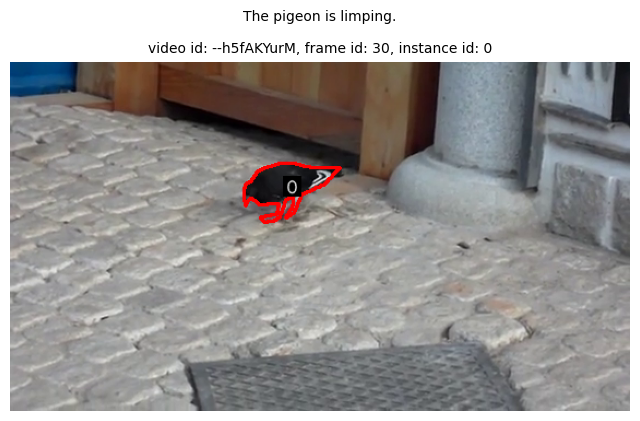

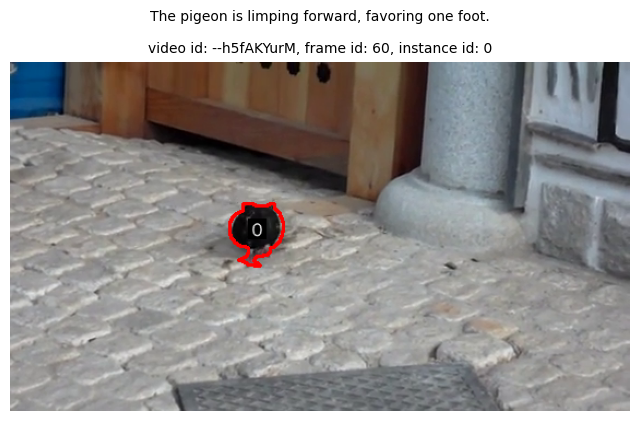

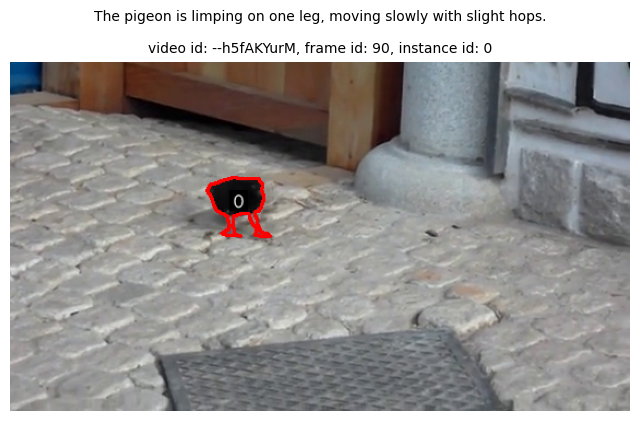

In [8]:
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

def load_captions(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def display_captioned_frame(idx, dataset, text_annotations, captions_dict):
    imgs, target = dataset[idx]
    frames_idx = target['frames_idx'].tolist()
    text_query, vid_id, frame_id, instance_id = text_annotations[idx]
    
    frame_id = frame_id - 1
    frame_order = frames_idx.index(frame_id)
    
    frame = imgs[frame_order, :, :, :].permute(1, 2, 0).numpy()
    frame = (frame).astype(np.uint8)
    
    mask = target['masks'].numpy().astype(np.uint8).squeeze()

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, contours, -1, (255, 0, 0), 2)

    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cx, cy = x + w // 2, y + h // 2
        bg_color = (0, 0, 0)
        text_color = (255, 255, 255)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1

        label_text = str(instance_id)
        (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)
        
        cv2.rectangle(frame, (cx - text_width // 2 - 3, cy - text_height - 3),
                      (cx + text_width // 2 + 3, cy + 3), bg_color, thickness=cv2.FILLED)
        cv2.putText(frame, label_text, (cx - text_width // 2, cy), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

    new_caption = captions_dict.get((vid_id, frame_id + 1, instance_id), "Caption not found")

    plt.figure(figsize=(8, 6))
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"{new_caption}\n\nvideo id: {vid_id}, frame id: {frame_id + 1}, instance id: {instance_id}", fontsize=10)
    plt.show()

json_path = "captions_train.json"
captions = load_captions(json_path)

captions_dict = {}
for item in captions:
    key = (item["video_id"], item["frame_id"], item["instance_id"])
    captions_dict[key] = item["caption"]

num_parts = 4
dataset_length = len(train_dataset) // 5000 # 15747개

part_size = dataset_length // num_parts
extra = dataset_length % num_parts

part_sizes = [part_size] * (num_parts - 1) + [part_size + extra]

user_part = int(input("Enter your part number (1-4): ")) - 1
if user_part not in range(num_parts):
    raise ValueError("Invalid part number. Enter a number between 1 and 4.") # 각자 파트에 해당되는 숫자 입력

start_idx = sum(part_sizes[:user_part])
end_idx = start_idx + part_sizes[user_part]

print(f"Displaying frames from index {start_idx} to {end_idx}")

print(f"Extracting captions from index {start_idx} to {end_idx}")

captions_part = [
    caption for i, caption in enumerate(captions) 
    if start_idx <= i < end_idx
]

part_json_path = f"captions_train_part{user_part+1}.json"
with open(part_json_path, "w", encoding="utf-8") as f:
    json.dump(captions_part, f, ensure_ascii=False, indent=4)

print(f"Saved {len(captions_part)} captions to {part_json_path}")

for i in range(start_idx, end_idx):
    display_captioned_frame(i, train_dataset, text_annotations, captions_dict)

Found matching data at index 15736. Displaying frame...


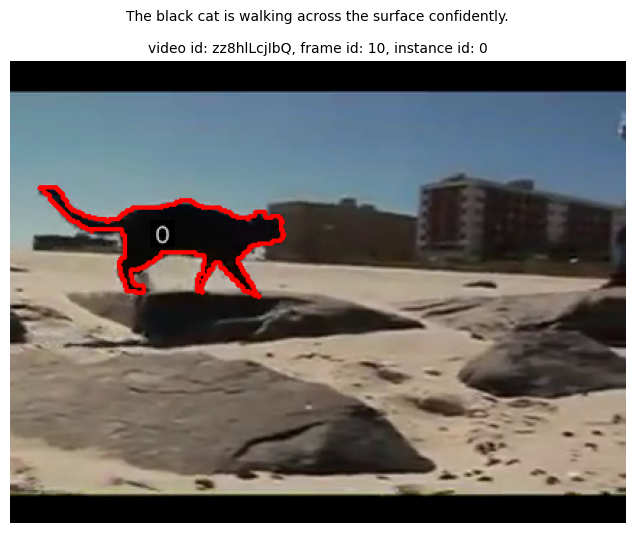

In [301]:
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

def load_captions(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def find_caption(video_id, frame_id, instance_id, captions_dict):
    return captions_dict.get((video_id, frame_id, instance_id), "Caption not found")

def find_dataset_index(video_id, frame_id, instance_id, text_annotations):
    for idx, annotation in enumerate(text_annotations):
        if annotation[1] == video_id and annotation[2] == frame_id and annotation[3] == instance_id:
            return idx
    return None

def display_captioned_frame(idx, dataset, text_annotations, captions_dict):
    imgs, target = dataset[idx]
    frames_idx = target['frames_idx'].tolist()
    text_query, vid_id, frame_id, instance_id = text_annotations[idx]
    
    frame_id = frame_id - 1
    frame_order = frames_idx.index(frame_id)
    
    frame = imgs[frame_order, :, :, :].permute(1, 2, 0).numpy()
    frame = (frame).astype(np.uint8)
    
    mask = target['masks'].numpy().astype(np.uint8).squeeze()

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, contours, -1, (255, 0, 0), 2)

    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cx, cy = x + w // 2, y + h // 2
        bg_color = (0, 0, 0)
        text_color = (255, 255, 255)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1

        label_text = str(instance_id)
        (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)
        
        cv2.rectangle(frame, (cx - text_width // 2 - 3, cy - text_height - 3),
                      (cx + text_width // 2 + 3, cy + 3), bg_color, thickness=cv2.FILLED)
        cv2.putText(frame, label_text, (cx - text_width // 2, cy), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

    new_caption = captions_dict.get((vid_id, frame_id + 1, instance_id), "Caption not found")

    plt.figure(figsize=(8, 6))
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"{new_caption}\n\nvideo id: {vid_id}, frame id: {frame_id + 1}, instance id: {instance_id}", fontsize=10)
    plt.show()
    
    plt.clf()
    plt.close()

json_path = "captions_train_part4.json"
captions = load_captions(json_path)

captions_dict = {(item["video_id"], item["frame_id"], item["instance_id"]): item["caption"] for item in captions}

video_id = input("Enter video_id: ") 
frame_id = int(input("Enter frame_id: "))  
instance_id = int(input("Enter instance_id: "))  

dataset_idx = find_dataset_index(video_id, frame_id, instance_id, text_annotations)

if dataset_idx is None:
    print("Error: No matching data found for the given video_id, frame_id, and instance_id.")
else:
    print(f"Found matching data at index {dataset_idx}. Displaying frame...")
    display_captioned_frame(dataset_idx, train_dataset, text_annotations, captions_dict)

### a2d val 시각화 코드 (+ 각자 파트 캡션 json 파일로 저장)

In [ ]:
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

def load_captions(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def display_captioned_frame(idx, dataset, text_annotations_val, captions_dict):
    imgs, target = dataset[idx]
    frames_idx = target['frames_idx'].tolist()
    text_query, vid_id, frame_id, instance_id = text_annotations_val[idx]
    
    frame_id = frame_id - 1
    frame_order = frames_idx.index(frame_id)
    
    frame = imgs[frame_order, :, :, :].permute(1, 2, 0).numpy()
    frame = (frame).astype(np.uint8)
    
    mask = target['masks'].numpy().astype(np.uint8).squeeze()

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, contours, -1, (255, 0, 0), 2)

    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cx, cy = x + w // 2, y + h // 2
        bg_color = (0, 0, 0)
        text_color = (255, 255, 255)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1

        label_text = str(instance_id)
        (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)
        
        cv2.rectangle(frame, (cx - text_width // 2 - 3, cy - text_height - 3),
                      (cx + text_width // 2 + 3, cy + 3), bg_color, thickness=cv2.FILLED)
        cv2.putText(frame, label_text, (cx - text_width // 2, cy), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

    new_caption = captions_dict.get((vid_id, frame_id + 1, instance_id), "Caption not found")

    plt.figure(figsize=(8, 6))
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"{new_caption}\n\nvideo id: {vid_id}, frame id: {frame_id + 1}, instance id: {instance_id}", fontsize=10)
    plt.show()

json_path = "captions_val.json"
captions = load_captions(json_path)

captions_dict = {}
for item in captions:
    key = (item["video_id"], item["frame_id"], item["instance_id"])
    captions_dict[key] = item["caption"]

num_parts = 4
dataset_length = len(val_dataset)  # 15747개
part_size = dataset_length // num_parts

user_part = int(input("Enter your part number (1-4): ")) - 1
if user_part not in range(num_parts):
    raise ValueError("Invalid part number. Enter a number between 1 and 4.") # 각자 파트에 해당되는 숫자 입력

start_idx = user_part * part_size
end_idx = min(start_idx + part_size, dataset_length)

part_start_idx = start_idx
part_end_idx = start_idx + part_size

print(f"Displaying frames from index {part_start_idx} to {part_end_idx}")

print(f"Extracting captions from index {part_start_idx} to {part_end_idx}")

captions_part = [
    caption for i, caption in enumerate(captions) 
    if part_start_idx <= i < part_end_idx
]

part_json_path = f"captions_val_part{user_part+1}.json"
with open(part_json_path, "w", encoding="utf-8") as f:
    json.dump(captions_part, f, ensure_ascii=False, indent=4)

print(f"Saved {len(captions_part)} captions to {part_json_path}")

for i in range(start_idx, end_idx):
    display_captioned_frame(i, val_dataset, text_annotations_val, captions_dict)

Found matching data at index 3785. Displaying frame...


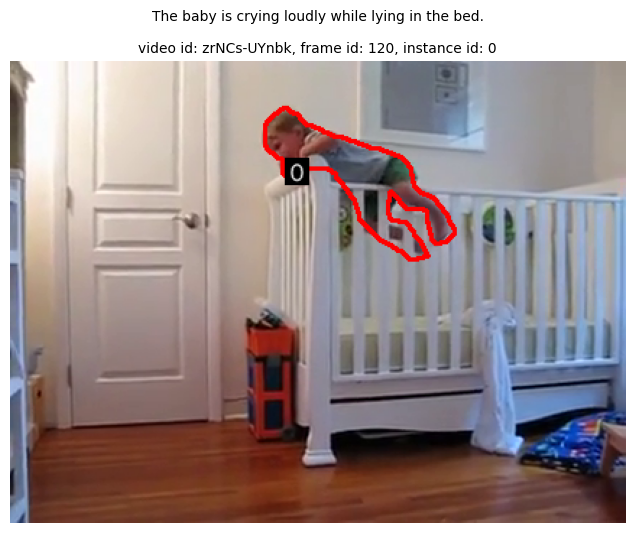

In [245]:
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

def load_captions(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def find_caption(video_id, frame_id, instance_id, captions_dict):
    return captions_dict.get((video_id, frame_id, instance_id), "Caption not found")

def find_dataset_index(video_id, frame_id, instance_id, text_annotations_val):
    for idx, annotation in enumerate(text_annotations_val):
        if annotation[1] == video_id and annotation[2] == frame_id and annotation[3] == instance_id:
            return idx
    return None

def display_captioned_frame(idx, dataset, text_annotations_val, captions_dict):
    imgs, target = dataset[idx]
    frames_idx = target['frames_idx'].tolist()
    text_query, vid_id, frame_id, instance_id = text_annotations_val[idx]
    
    frame_id = frame_id - 1
    frame_order = frames_idx.index(frame_id)
    
    frame = imgs[frame_order, :, :, :].permute(1, 2, 0).numpy()
    frame = (frame).astype(np.uint8)
    
    mask = target['masks'].numpy().astype(np.uint8).squeeze()

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame, contours, -1, (255, 0, 0), 2)

    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cx, cy = x + w // 2, y + h // 2
        bg_color = (0, 0, 0)
        text_color = (255, 255, 255)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1

        label_text = str(instance_id)
        (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)
        
        cv2.rectangle(frame, (cx - text_width // 2 - 3, cy - text_height - 3),
                      (cx + text_width // 2 + 3, cy + 3), bg_color, thickness=cv2.FILLED)
        cv2.putText(frame, label_text, (cx - text_width // 2, cy), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

    new_caption = captions_dict.get((vid_id, frame_id + 1, instance_id), "Caption not found")

    plt.figure(figsize=(8, 6))
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"{new_caption}\n\nvideo id: {vid_id}, frame id: {frame_id + 1}, instance id: {instance_id}", fontsize=10)
    plt.show()
    
    plt.clf()
    plt.close()

json_path = "captions_val_part4.json"
captions = load_captions(json_path)

captions_dict = {(item["video_id"], item["frame_id"], item["instance_id"]): item["caption"] for item in captions}

video_id = input("Enter video_id: ") 
frame_id = int(input("Enter frame_id: "))  
instance_id = int(input("Enter instance_id: "))  

dataset_idx = find_dataset_index(video_id, frame_id, instance_id, text_annotations_val)

if dataset_idx is None:
    print("Error: No matching data found for the given video_id, frame_id, and instance_id.")
else:
    print(f"Found matching data at index {dataset_idx}. Displaying frame...")
    display_captioned_frame(dataset_idx, val_dataset, text_annotations_val, captions_dict)